In [ ]:
import transformers
import csv
import torch
import numpy as np
from torch.nn import Linear
import codecs
import random
from tqdm import tqdm
import os
import pickle
from transformers import PreTrainedTokenizer
from transformers.tokenization_utils_base import BatchEncoding

In [ ]:
!pip install natasha

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 93.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=e91b426690a558ba735e9c5c38c9a9704e3bb8e03b51481081bd0c332212946a
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=89c73434b439db6a9117bba301bf8c9203e4aa05462c4c33c8d91732002e79c8
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree


In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: train/
   creating: train/marks/
  inflating: train/marks/book_1000.txt  
  inflating: train/marks/book_1007.txt  
  inflating: train/marks/book_1026.txt  
  inflating: train/marks/book_1080.txt  
  inflating: train/marks/book_1096.txt  
  inflating: train/marks/book_1101.txt  
  inflating: train/marks/book_1132.txt  
  inflating: train/marks/book_1146.txt  
  inflating: train/marks/book_1162.txt  
  inflating: train/marks/book_1185.txt  
  inflating: train/marks/book_1197.txt  
  inflating: train/marks/book_1200.txt  
  inflating: train/marks/book_1204.txt  
  inflating: train/marks/book_1206.txt  
  inflating: train/marks/book_1214.txt  
  inflating: train/marks/book_1218.txt  
  inflating: train/marks/book_1237.txt  
  inflating: train/marks/book_1259.txt  
  inflating: train/marks/book_1263.txt  
  inflating: train/marks/book_1297.txt  
  inflating: train/marks/book_1306.txt  
  inflating: train/marks/book_1311.txt  
  inflating: train/marks/book_13

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)

def parsing_process(s):
    segmenter = Segmenter()
    morph_vocab = MorphVocab()

    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    syntax_parser = NewsSyntaxParser(emb)
    ner_tagger = NewsNERTagger(emb)

    names_extractor = NamesExtractor(morph_vocab)
    doc = Doc(s)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    doc.parse_syntax(syntax_parser)
    return doc

def find_candidates(l, word, sen):
    result = []

    for i in l:
        if i.pos == "NOUN" or i.pos == "PROPN":
             result.append(i)

    return result

def find_anaphors_clean(doc):
    result = []
    prevprev = []
    prev = []

    for sen in doc.sents:
        cur = []

        for word in sen.tokens:
            cur.append(word)

            if word.pos == "PRON":
                if "Person" in  word.feats and word.feats["Person"] == '3':
                    candidates = find_candidates(prevprev + prev + cur, word, sen)
                    result.append([word, candidates, prevprev + prev + sen.tokens])

        prevprev = prev
        prev = cur

    return result

In [ ]:
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"
set_global_seed(42)
device

'cuda'

In [ ]:
def support_sentence(propn:str, candidate:str)->str:
    return f'Отсылается ли местоимение {propn} к сущности {candidate}?'

def humanize(doc):
    s = ""
    for token in doc:
        s += token.text + " "
    return s

def create_dataset(folder:str):
    dataset = []
    targets = []
    it = 1

    for file_name in sorted(os.listdir(f"{folder}/texts")):
        print(it, "out of", len(os.listdir(f"{folder}/texts")), "files processed")
        it += 1
        text_file = f"{folder}/texts/" + file_name
        mark_file = f"{folder}/marks/" + file_name
        text = open(text_file, encoding='utf-16').read()
        mark = open(mark_file, encoding='utf-16').read().split('\n')
        mark_map = {}

        for i in mark:
            s = i.split()

            if s[1] != "-":
                mark_map[int(s[0])] = s[1:]

        doc = parsing_process(text)
        anaph = find_anaphors_clean(doc)

        for word, cands, sen in anaph:

            if word.start in mark_map:
                target_lems = mark_map[word.start]

                for c in cands:
                    dataset.append(humanize(sen) + support_sentence(word.text, c.lemma))
                    if c.lemma in target_lems:
                        targets.append(1)
                    else:
                        targets.append(0)

    return dataset, targets

model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
dataset, targets = create_dataset("train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1 out of 101 files processed
2 out of 101 files processed
3 out of 101 files processed
4 out of 101 files processed
5 out of 101 files processed
6 out of 101 files processed
7 out of 101 files processed
8 out of 101 files processed
9 out of 101 files processed
10 out of 101 files processed
11 out of 101 files processed
12 out of 101 files processed
13 out of 101 files processed
14 out of 101 files processed
15 out of 101 files processed
16 out of 101 files processed
17 out of 101 files processed
18 out of 101 files processed
19 out of 101 files processed
20 out of 101 files processed
21 out of 101 files processed
22 out of 101 files processed
23 out of 101 files processed
24 out of 101 files processed
25 out of 101 files processed
26 out of 101 files processed
27 out of 101 files processed
28 out of 101 files processed
29 out of 101 files processed
30 out of 101 files processed
31 out of 101 files processed
32 out of 101 files processed
33 out of 101 files processed
34 out of 101 files

In [ ]:
class TransformersDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        token_seq,
        label_seq
    ):
        self.token_seq = token_seq
        self.label_seq = label_seq

    def __len__(self):
        return len(self.token_seq)

    def __getitem__(self, idx):
        tokens = self.token_seq[idx]
        labels = self.label_seq[idx]

        return tokens, labels

train_dataset = TransformersDataset(
    token_seq=dataset,
    label_seq=targets,
)

train_dataset[0]

('« Несомненно , польская сторона была удивлена столь скорой оглаской доклада МАК , а также способом подачи некоторых его частей . Тем не менее в такой ситуации следует запастись большим хладнокровием и ответить таким образом , чтобы не уменьшить шансы на сближение позиций » , — заключил Коморовский . Напомним , премьер-министр Польши Дональд Туск заявил , что правительство считает доклад МАК неполным , так как в него были включены не все замечания польской стороны . Отсылается ли местоимение него к сущности сторона?',
 0)

In [ ]:
class TransformersCollator:
    def __init__(
        self,
        tokenizer: PreTrainedTokenizer,
        tokenizer_kwargs
    ):
        self.tokenizer = tokenizer
        self.tokenizer_kwargs = tokenizer_kwargs

    def __call__(
        self,
        batch,
    ):
        tokens, labels = zip(*batch)
        tokens = self.tokenizer(tokens, **self.tokenizer_kwargs)

        return tokens, torch.tensor(labels).float()

tokenizer_kwargs = {
    "padding":                True,
    "truncation":             True,
    "max_length":             512,
    "return_tensors":         "pt",
}

collator = TransformersCollator(
    tokenizer=tokenizer,
    tokenizer_kwargs=tokenizer_kwargs
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collator,
)

tokens, labels = next(iter(train_dataloader))

tokens = tokens.to(device)
labels = labels.to(device)
print(tokens)
print(labels)

{'input_ids': tensor([[  101, 68251, 10604,  ..., 76927,   166,   102],
        [  101, 67691,   128,  ...,     0,     0,     0],
        [  101, 34461, 12140,  ...,     0,     0,     0],
        ...,
        [  101,  6762,  6023,  ...,     0,     0,     0],
        [  101, 27617,   128,  ...,     0,     0,     0],
        [  101,   781, 25553,  ...,     0,     0,     0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}
tensor([1., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


In [ ]:
class BERTAnaphora(torch.nn.Module):
    def __init__(
        self,
        bert,
        embedding_dim
    ):
        super().__init__()
        self.bert = bert
        self.hidden = Linear(embedding_dim, 300, bias=True)
        self.head = Linear(300, 2, bias=True)

    def forward(self, tokens):
        embed = self.bert(**tokens, output_hidden_states=True).last_hidden_state[:,0,:]
        vec = self.hidden(embed)
        return self.head(vec)

In [ ]:
bert = transformers.AutoModel.from_pretrained(model_name)
embedding_dim = 768
model = BERTAnaphora(bert, embedding_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0]).to(device))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = [None]
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int
) -> None:
    model.train()

    epoch_loss = []

    for i, (tokens, labels) in tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc="loop over train batches",
    ):
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    avg_loss = np.mean(epoch_loss)
    train_losses.append(avg_loss)
    print(f"Train loss: {avg_loss}\n")

def train(
    n_epochs: int,
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device
) -> None:
    for epoch in range(n_epochs):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")

        train_epoch(
            model=model,
            dataloader=dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch=epoch
        )

train(
    n_epochs=11,
    model=model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device
)

Epoch [1 / 11]



loop over train batches:  23%|██▎       | 254/1094 [01:07<03:42,  3.77it/s]


KeyboardInterrupt: 

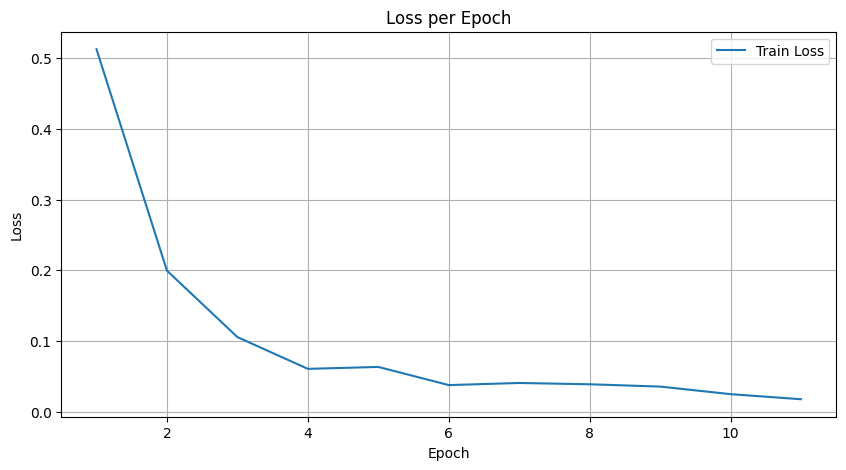

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/marks/
  inflating: test/marks/book_1093.txt  
  inflating: test/marks/book_1188.txt  
  inflating: test/marks/book_1473.txt  
  inflating: test/marks/book_1543.txt  
  inflating: test/marks/book_1580.txt  
  inflating: test/marks/book_1633.txt  
  inflating: test/marks/book_1639.txt  
  inflating: test/marks/book_1665.txt  
  inflating: test/marks/book_1741.txt  
  inflating: test/marks/book_1799.txt  
  inflating: test/marks/book_3183.txt  
  inflating: test/marks/book_3186.txt  
  inflating: test/marks/book_3261.txt  
   creating: test/texts/
  inflating: test/texts/book_1093.txt  
  inflating: test/texts/book_1188.txt  
  inflating: test/texts/book_1473.txt  
  inflating: test/texts/book_1543.txt  
  inflating: test/texts/book_1580.txt  
  inflating: test/texts/book_1633.txt  
  inflating: test/texts/book_1639.txt  
  inflating: test/texts/book_1665.txt  
  inflating: test/texts/book_1741.txt  
  inflating: test/texts/book_179

In [ ]:
test_dataset, test_targets = create_dataset("test")
test_tokens = []
for t in test_dataset:
    test_tokens.append(tokenizer(t, **tokenizer_kwargs).to(device))
test_dataset[0], test_targets[0], test_tokens[0]

1 out of 13 files processed
2 out of 13 files processed
3 out of 13 files processed
4 out of 13 files processed
5 out of 13 files processed
6 out of 13 files processed
7 out of 13 files processed
8 out of 13 files processed
9 out of 13 files processed
10 out of 13 files processed
11 out of 13 files processed
12 out of 13 files processed
13 out of 13 files processed


('Для справки : Infox было решено запустить в середине августа 2008 года , как раз после начала резкого обвала биржевых индексов в России . По словам главного редактора издания Александра Писарева , это большой плюс : все остальные издания , и уже существующие , и свежезапустившиеся , рассчитывали на рекламные деньги как в конце года , так и в начале следующего . Они этих денег не получат , как и Infox , но Infox на них и не рассчитывал » . Отсылается ли местоимение Они к сущности справка?',
 0,
 {'input_ids': tensor([[   101,   7638,  84264,    156,  44476,    279,   3332,  20763,  40517,
             845,  11639,   6023,   6564,   1768,    128,   2739,   2226,   3468,
            8086,  47275,  92982,  76787,  51194,    845,   3590,    132,   3099,
            6335,  12628,  25304,  12168,  11797,  91198,    626,    128,   3998,
           11333,  28317,    156,   4752,  16969,  12168,    128,    851,   4745,
           41258,    128,    851,  76676,  63838, 115141,  63832,    128,  

In [ ]:
labels = []

with torch.no_grad():
    model.eval()

    for test in test_tokens:
        result = model(test)
        result = torch.argmax(result)
        labels.append(result.item())

labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = np.array(test_targets)
y_pred = np.array(labels)

# Метрики
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred) * 100
recall = recall_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")  # Точность (сколько из предсказанных 1 действительно 1)
print(f"Recall: {recall:.2f}%")        # Полнота (сколько реальных 1 правильно предсказано)
print(f"F1-score: {f1:.2f}%")           # Гармоническое среднее precision и recall

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 93.06%
Precision: 65.03%
Recall: 86.92%
F1-score: 74.40%

Confusion Matrix:
[[765  50]
 [ 14  93]]


In [ ]:
print("Test files processing")
print("-------------------------")
it = 1
true_labels = 0
false_labels = 0

with torch.no_grad():
    model.eval()
    for file_name in sorted(os.listdir("test/texts")):
        print(it, "out of", len(os.listdir("test/texts")), "files processed")
        it += 1

        text_file = "test/texts/" + file_name
        mark_file = "test/marks/" + file_name

        with open(text_file, encoding='utf-16') as f:
            text = f.read()

        with open(mark_file, encoding='utf-16') as f:
            mark = f.read().split('\n')

        mark_map = {}

        for i in mark:
            s = i.split()

            if s[1] != "-":
                mark_map[int(s[0])] = s[1:]

        doc = parsing_process(text)
        anaphs = find_anaphors_clean(doc)
        predictions = {}

        for word, candidates, sen in anaphs:
            for c in candidates:
                tokens = tokenizer(humanize(sen) + support_sentence(word.text, c.lemma), **tokenizer_kwargs).to(device)
                result = model(tokens)
                if torch.argmax(result).item() == 1:
                    if word.start in predictions:
                        predictions[word.start].append(c.lemma)
                    else:
                        predictions[word.start] = [c.lemma]

            if word.start in predictions:
                predictions[word.start] = set(predictions[word.start])

        for i in mark_map:
            if not i in predictions:
                false_labels += 1
                print(mark_map[i])
                continue
            print(predictions[i], mark_map[i])
            if predictions[i].issubset(set(mark_map[i])):
                true_labels += 1
            else:
                false_labels += 1

    print("Done")
    print("-------------------------")
    print("got", true_labels + false_labels, "test marks")
    print("model accuracy:", true_labels / (true_labels + false_labels))

Test files processing
-------------------------
1 out of 13 files processed
{'деньга'} ['издание']
{'деньга', 'слово', 'infox'} ['деньга']
2 out of 13 files processed
{'стена'} ['стена']
{'стена'} ['стена']
{'француз', 'ямакаси', 'участник'} ['француз']
{'стена'} ['стена']
{'член', 'участник'} ['участник']
{'фильм', 'показ'} ['фильм']
3 out of 13 files processed
{'леха'} ['леха']
{'бомж'} ['бомж']
4 out of 13 files processed
{'проект'} ['проект']
{'президент', 'сикорский'} ['президент']
5 out of 13 files processed
{'ракета'} ['ракета']
{'ракета'} ['ракета']
{'тайвань'} ['ракета']
6 out of 13 files processed
{'задача'} ['задача']
{'информация'} ['информация']
{'код'} ['код']
{'delete'} ['запись']
{'зараза'} ['зараза']
{'решение'} ['решение']
{'вещь', 'теоретик'} ['вещь']
7 out of 13 files processed
{'заказчик'} ['заказчик']
{'практика', 'проблема'} ['проблема']
{'код'} ['код']
{'заказчик'} ['вопрос']
8 out of 13 files processed
{'реформа'} ['реформа']
9 out of 13 files processed
{'лицо'

In [ ]:
print("Test files processing")
print("-------------------------")
it = 1
true_labels = 0
false_labels = 0

with torch.no_grad():
    model.eval()
    for file_name in sorted(os.listdir("test/texts")):
        print(it, "out of", len(os.listdir("test/texts")), "files processed")
        it += 1

        text_file = "test/texts/" + file_name
        mark_file = "test/marks/" + file_name

        with open(text_file, encoding='utf-16') as f:
            text = f.read()

        with open(mark_file, encoding='utf-16') as f:
            mark = f.read().split('\n')

        mark_map = {}

        for i in mark:
            s = i.split()

            if s[1] != "-":
                mark_map[int(s[0])] = s[1:]

        doc = parsing_process(text)
        anaphs = find_anaphors_clean(doc)
        predictions = {}

        for word, candidates, sen in anaphs:
            max_value = -1000000
            for c in candidates:
                tokens = tokenizer(humanize(sen) + support_sentence(word.text, c.lemma), **tokenizer_kwargs).to(device)
                result = model(tokens)
                if (result[0][1] - result[0][0]).item() > max_value:
                    predictions[word.start] = c.lemma
                    max_value = (result[0][1] - result[0][0]).item()

            print(max_value)

        for i in mark_map:
            print(predictions[i], mark_map[i])
            if predictions[i] in mark_map[i]:
                true_labels += 1
            else:
                false_labels += 1

    print("Done")
    print("-------------------------")
    print("got", true_labels + false_labels, "test marks")
    print("model accuracy:", true_labels / (true_labels + false_labels))

Test files processing
-------------------------
1 out of 13 files processed
6.947457313537598
7.076336860656738
деньга ['издание']
деньга ['деньга']
2 out of 13 files processed
7.014900207519531
5.849098205566406
4.302762031555176
7.295087814331055
5.832076072692871
5.2543182373046875
стена ['стена']
стена ['стена']
француз ['француз']
стена ['стена']
член ['участник']
фильм ['фильм']
3 out of 13 files processed
2.8696646690368652
6.1828765869140625
леха ['леха']
бомж ['бомж']
4 out of 13 files processed
5.749294281005859
6.846325874328613
проект ['проект']
президент ['президент']
5 out of 13 files processed
7.252163887023926
7.083918571472168
3.1533091068267822
ракета ['ракета']
ракета ['ракета']
тайвань ['ракета']
6 out of 13 files processed
1.8258296251296997
6.99161434173584
2.889564037322998
1.4530739784240723
0.1749790608882904
0.5598155856132507
2.1469151973724365
задача ['задача']
информация ['информация']
код ['код']
delete ['запись']
зараза ['зараза']
решение ['решение']
вещь

In [ ]:
model

BERTAnaphora(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
import pickle

with open('bert.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

In [ ]:
text = "К сожалению, ни один наш оператор не может обеспечить устойчивой связи: они имеют дело с радиорелейными станциями на земле, а нужны спутниковые возможности, компании, которые могут предоставлять спутниковые услуги."

doc = parsing_process(text)
anaphs = find_anaphors_clean(doc)
predictions = {}

for word, candidates, sen in anaphs:
    for c in candidates:
        tokens = tokenizer(humanize(sen) + support_sentence(word.text, c.lemma), **tokenizer_kwargs).to(device)
        result = model(tokens)
        if torch.argmax(result).item() == 1:
            if word.start in predictions:
                predictions[word.start].append(c.lemma)
            else:
                predictions[word.start] = [c.lemma]

    if word.start in predictions:
        predictions[word.start] = set(predictions[word.start])

predictions

{72: {'оператор'}}

In [ ]:
text = "Суд в Москве арестовал бывшего губернатора Курской области Алексея Смирнова. Его отправили в СИЗО на два месяца."

doc = parsing_process(text)
anaphs = find_anaphors_clean(doc)
predictions = {}

for word, candidates, sen in anaphs:
    for c in candidates:
        tokens = tokenizer(humanize(sen) + support_sentence(word.text, c.lemma), **tokenizer_kwargs).to(device)
        result = model(tokens)
        if torch.argmax(result).item() == 1:
            if word.start in predictions:
                predictions[word.start].append(c.lemma)
            else:
                predictions[word.start] = [c.lemma]

    if word.start in predictions:
        predictions[word.start] = set(predictions[word.start])

predictions

{77: {'губернатор', 'смирнов'}}

In [ ]:
text = "Вася и Петя играют в догонялки, они очень любят эту игру."

doc = parsing_process(text)
anaphs = find_anaphors_clean(doc)
predictions = {}

for word, candidates, sen in anaphs:
    for c in candidates:
        tokens = tokenizer(humanize(sen) + support_sentence(word.text, c.lemma), **tokenizer_kwargs).to(device)
        result = model(tokens)
        if torch.argmax(result).item() == 1:
            if word.start in predictions:
                predictions[word.start].append(c.lemma)
            else:
                predictions[word.start] = [c.lemma]

    if word.start in predictions:
        predictions[word.start] = set(predictions[word.start])

predictions

{32: {'вася', 'петя'}}